In [6]:
import numpy as np 
import pandas as pd
import statsmodels.api as sm 
import math
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, roc_curve, auc
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19 # Using VGG19 as the TableNet backbone
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_preprocess_input
from tensorflow.image import resize


In [8]:

# --- CONFIGURATION & PATHS (Ensure Consistency) ---
TARGET_COLUMN = 'fraud_reported'
DATA_PATH = '/kaggle/input/augmented-data-of-insurance-fraud/augmented_dataset3.csv'

VGG_WEIGHTS_PATH = '/kaggle/input/vgg19-pre-trained-weights-keras/tensorflow2/vgg-19/1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5' 


INPUT_IMAGE_SIZE = 224 

# Consistency Parameters (Must be IDENTICAL to DNN/GoogleNet)
TEST_SIZE = 0.3
RANDOM_STATE = 42
CORR_THRESHOLD = 0.9
SL_THRESHOLD = 0.05

# Training Parameters (Memory and Consistency)
MEM_SAFE_BATCH_SIZE = 16 
LEARNING_RATE = 1e-4 
EPOCHS = 15


In [9]:

df = pd.read_csv('/kaggle/input/augmented-data-of-insurance-fraud/augmented_dataset3.csv')
TARGET_COLUMN = 'fraud_reported'
X = df.drop([TARGET_COLUMN], axis=1)
y = df[TARGET_COLUMN]
    

In [10]:
# --- 1. Custom Preprocessing Functions (For Tabular Feature Selection) ---

def remove_high_correlation(X_data, threshold=0.9):
    if not isinstance(X_data, pd.DataFrame): X_data = pd.DataFrame(X_data) 
    col_corr = set() 
    corr_matrix = X_data.corr().abs() 
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                col_corr.add(corr_matrix.columns[i])
    X_data_reduced = X_data.drop(columns=list(col_corr), axis=1)
    return X_data_reduced

def backward_elimination(X_data, y_data, sl=0.05):
    X_np = X_data.values
    y_np = y_data.values
    X_np = sm.add_constant(X_np) 
    original_columns = np.array(['const'] + list(X_data.columns))
    numVars = X_np.shape[1]
    
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y_np, X_np).fit()
        max_p_value = max(regressor_OLS.pvalues).astype(float)
        if max_p_value > sl:
            max_p_index = list(regressor_OLS.pvalues).index(max_p_value)
            X_np = np.delete(X_np, max_p_index, 1)
            original_columns = np.delete(original_columns, max_p_index)
        else: break
            
    if 'const' in original_columns:
        const_index = np.where(original_columns == 'const')[0][0]
        X_np = np.delete(X_np, const_index, 1)
        original_columns = np.delete(original_columns, const_index)

    return pd.DataFrame(X_np, columns=original_columns), original_columns


In [11]:

# --- 2. Data Loading and Splitting ---

df = pd.read_csv(DATA_PATH)
X = df.drop([TARGET_COLUMN], axis=1)
y = df[TARGET_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)



In [12]:

# --- 3. Feature Selection (Consistency with Deep ANN) ---

# A. Correlation Threshold Removal
X_train_corr_reduced = remove_high_correlation(X_train, threshold=CORR_THRESHOLD)
X_test_corr_reduced = X_test[X_train_corr_reduced.columns] 

# B. Backward Elimination
X_train_final_df, final_features = backward_elimination(X_train_corr_reduced, y_train, sl=SL_THRESHOLD)
X_test_final_df = X_test_corr_reduced[final_features]

X_train_final = X_train_final_df.values
X_test_final = X_test_final_df.values

print(f"Tabular features (Train) after selection: {X_train_final.shape}")


Tabular features (Train) after selection: (8079, 24)


In [13]:
# --- 4. Image Preparation (Memory-Safe Small Images) ---

def transform_to_small_image(X_data):
    """Pads and reshapes tabular data to the small 8x8x3 format (memory-safe)."""
    padded_features = 64
    padding_needed = padded_features - X_data.shape[1]
    X_padded = np.pad(X_data, ((0, 0), (0, padding_needed)), mode='constant')
    X_images = X_padded.reshape(-1, 8, 8, 1) 
    X_images_rgb = np.concatenate([X_images] * 3, axis=-1) 
    return X_images_rgb

# Create the memory-safe small image arrays
X_train_small = transform_to_small_image(X_train_final)
X_test_small = transform_to_small_image(X_test_final)

y_train_np = y_train.values.ravel()
y_test_np = y_test.values.ravel()



In [14]:
# --- 5. Memory-Safe Custom Batch Generator (Modified for VGG Preprocessing) ---

def tablenet_batch_generator(X_small_images, Y_labels, batch_size, target_size=(INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)):
    """
    Generator that performs resizing and VGG19 preprocessing batch-by-batch.
    """
    num_samples = len(X_small_images)
    indices = np.arange(num_samples)
    
    while True:
        np.random.shuffle(indices)
        
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            
            X_batch_small = X_small_images[batch_indices]
            Y_batch = Y_labels[batch_indices]
            
            # 1. Resizing (Batch-by-batch)
            X_batch_resized = np.array([resize(img, target_size, method='nearest').numpy() 
                                        for img in X_batch_small])
            
            # 2. Preprocessing (VGG specific preprocessing)
            X_batch_preprocessed = vgg_preprocess_input(X_batch_resized)
            
            yield X_batch_preprocessed, Y_batch

# Instantiate Generators
train_generator = tablenet_batch_generator(X_train_small, y_train_np, batch_size=MEM_SAFE_BATCH_SIZE)
validation_generator = tablenet_batch_generator(X_test_small, y_test_np, batch_size=MEM_SAFE_BATCH_SIZE)

STEPS_PER_EPOCH = math.ceil(len(X_train_small) / MEM_SAFE_BATCH_SIZE)
VALIDATION_STEPS = math.ceil(len(X_test_small) / MEM_SAFE_BATCH_SIZE)



In [15]:
#  --- 6. Load TableNet-Inspired Model (VGG19 Backbone) ---

# Load VGG19, set weights=None, and load them manually to use local file
base_model = VGG19(weights=None, include_top=False, input_shape=(INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE, 3))
base_model.load_weights(VGG_WEIGHTS_PATH)

# Freeze the base model (VGG19)
base_model.trainable = False 

# Custom Classification Head (Similar structure to GoogleNet/DNN)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) 
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)  
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile Model with a low learning rate
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)


In [16]:
# --- 7. Model Training (Phase 1) ---
print("\n--- Training TableNet-Inspired Model (VGG19) ---")
history = model.fit(
    train_generator, 
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator, 
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS, 
    verbose=1
)


--- Training TableNet-Inspired Model (VGG19) ---
Epoch 1/15
505/505 [==============================] - 72s 142ms/step - loss: 786.5316 - accuracy: 0.4983 - val_loss: 457.7296 - val_accuracy: 0.5045
Epoch 2/15
505/505 [==============================] - 72s 142ms/step - loss: 549.7585 - accuracy: 0.5090 - val_loss: 657.7109 - val_accuracy: 0.5319
Epoch 3/15
505/505 [==============================] - 72s 143ms/step - loss: 466.9301 - accuracy: 0.5152 - val_loss: 337.3587 - val_accuracy: 0.5215
Epoch 4/15
505/505 [==============================] - 71s 141ms/step - loss: 391.4024 - accuracy: 0.5049 - val_loss: 252.5361 - val_accuracy: 0.4929
Epoch 5/15
505/505 [==============================] - 72s 142ms/step - loss: 344.6238 - accuracy: 0.4991 - val_loss: 347.3312 - val_accuracy: 0.4958
Epoch 6/15
505/505 [==============================] - 72s 142ms/step - loss: 299.9187 - accuracy: 0.5107 - val_loss: 81.0732 - val_accuracy: 0.5074
Epoch 7/15
505/505 [==============================] - 73s


--- Model Evaluation and Metrics ---
217/217 [==============================] - 22s 101ms/step

--- TableNet-Inspired Model Final Metrics ---
Overall Accuracy: 0.5201
------------------------------
Precision (Fraud / Class 1): 0.5143
Recall (Fraud / Class 1): 0.8579
F1-Score (Fraud / Class 1): 0.6430
------------------------------

Full Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.18      0.27      1718
           1       0.51      0.86      0.64      1745

    accuracy                           0.52      3463
   macro avg       0.53      0.52      0.46      3463
weighted avg       0.53      0.52      0.46      3463



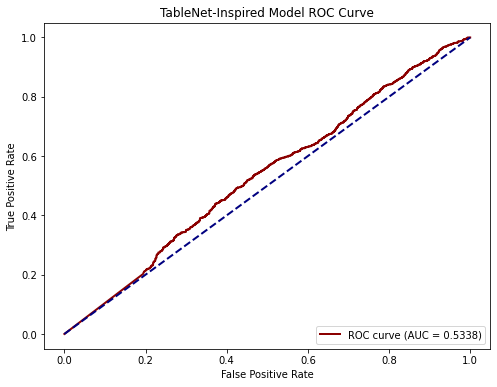

In [17]:
# --- 8. Evaluation and Metric Extraction (Identical to GoogleNet) ---

def tablenet_evaluation_generator(X_small_images, Y_labels, batch_size, target_size=(INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)):
    """A non-shuffling generator for fixed-order evaluation."""
    num_samples = len(X_small_images)
    indices = np.arange(num_samples) 
    
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        batch_indices = indices[start:end]
        
        X_batch_small = X_small_images[batch_indices]
        Y_batch = Y_labels[batch_indices]
        
        X_batch_resized = np.array([resize(img, target_size, method='nearest').numpy() 
                                    for img in X_batch_small])
        X_batch_preprocessed = vgg_preprocess_input(X_batch_resized)
        
        yield X_batch_preprocessed, Y_batch


print("\n--- Model Evaluation and Metrics ---")

# Create non-shuffling prediction generator
prediction_generator = tablenet_evaluation_generator(X_test_small, y_test_np, batch_size=MEM_SAFE_BATCH_SIZE)

# Predict probabilities
y_pred_proba_cnn = model.predict(prediction_generator, steps=VALIDATION_STEPS, verbose=1)

# Get true labels and predicted classes
y_test_cnn_true = y_test_np 
y_pred_cnn = (y_pred_proba_cnn > 0.5).astype(int)

# Length check
if len(y_pred_proba_cnn) != len(y_test_cnn_true):
    y_test_cnn_true = y_test_cnn_true[:len(y_pred_proba_cnn)]

# Calculate Specific Metrics
cnn_accuracy = accuracy_score(y_test_cnn_true, y_pred_cnn)
precision, recall, f1_score, support = precision_recall_fscore_support(
    y_test_cnn_true, y_pred_cnn, labels=[0, 1], average=None
)

# Output results
print(f"\n--- TableNet-Inspired Model Final Metrics ---")
print(f"Overall Accuracy: {cnn_accuracy:.4f}")
print("-" * 30)
print(f"Precision (Fraud / Class 1): {precision[1]:.4f}")
print(f"Recall (Fraud / Class 1): {recall[1]:.4f}")
print(f"F1-Score (Fraud / Class 1): {f1_score[1]:.4f}")
print("-" * 30)

# Full Classification Report and ROC Plot
print("\nFull Classification Report:")
print(classification_report(y_test_cnn_true, y_pred_cnn))

fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test_cnn_true, y_pred_proba_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn, tpr_cnn, color='darkred', lw=2, label=f'ROC curve (AUC = {roc_auc_cnn:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('TableNet-Inspired Model ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()